# Radioactive Decay Chain Modeling with PINNs

This notebook models a simple radioactive decay chain using Physics-Informed Neural Networks (PINNs).  
The system of equations is:

\begin{align}
\frac{dN_1}{dt} &= -\lambda_1 N_1 \\
\frac{dN_2}{dt} &= \lambda_1 N_1 - \lambda_2 N_2 \\
\frac{dN_3}{dt} &= \lambda_2 N_2
\end{align}

This represents a decay sequence: \( N_1 \rightarrow N_2 \rightarrow N_3 \)

We will define the system, generate synthetic data, and train a neural network to approximate the dynamics while enforcing physical constraints via PINNs.


## Load packages and set seed

In [160]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

seed = 42

## Simulate data

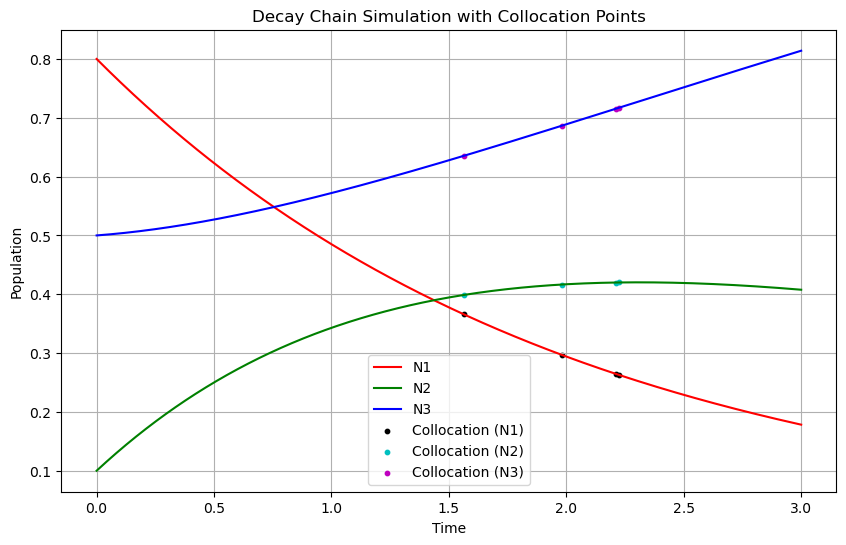

In [167]:
np.random.seed(seed)

# Decay constants
lambda1 = 0.5
lambda2 = 0.3

# Time points
t_start = 0
t_end = 3
prediction_time = 3 # length of prediction

t = np.linspace(t_start, t_end, 1000)
dt = t[1] - t[0]

# Initial conditions
N1_0, N2_0, N3_0 = .8, .1, .5

# Initialize arrays
N1, N2, N3 = np.zeros_like(t), np.zeros_like(t), np.zeros_like(t)
N1[0], N2[0], N3[0] = N1_0, N2_0, N3_0

# Euler integration
for i in range(1, len(t)):
    dN1 = -lambda1 * N1[i-1]
    dN2 = lambda1 * N1[i-1] - lambda2 * N2[i-1]
    dN3 = lambda2 * N2[i-1]
    N1[i] = N1[i-1] + dN1 * dt
    N2[i] = N2[i-1] + dN2 * dt
    N3[i] = N3[i-1] + dN3 * dt

# Tensors for full supervised data and evaluation
t_tensor = torch.tensor(t, dtype=torch.float32).view(-1, 1)
N_data = torch.tensor(np.stack([N1, N2, N3], axis=1), dtype=torch.float32)

# Collocation points (used by PINN for residual loss)
n_collocation = 4
indices = np.random.choice(len(t), n_collocation, replace=False)
indices = np.sort(indices)
t_col = torch.tensor(t[indices], dtype=torch.float32).view(-1, 1).requires_grad_(True)
N_col = N_data[indices]

# Plot simulated data and collocation points
plt.figure(figsize=(10, 6))
plt.plot(t, N1, 'r', label='N1')
plt.plot(t, N2, 'g', label='N2')
plt.plot(t, N3, 'b', label='N3')
plt.scatter(t[indices], N1[indices], color='k', s=10, label='Collocation (N1)')
plt.scatter(t[indices], N2[indices], color='c', s=10, label='Collocation (N2)')
plt.scatter(t[indices], N3[indices], color='m', s=10, label='Collocation (N3)')
plt.title("Decay Chain Simulation with Collocation Points")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.grid(True)
plt.show()


## Define ANN

In [169]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 8), nn.Tanh(),
            nn.Linear(8, 8), nn.Tanh(),
            nn.Linear(8, 3)
        )

    def forward(self, t):
        return self.net(t)

def compute_derivatives(y, t):
    dy = grad(y, t, torch.ones_like(y), create_graph=True)[0]
    return dy

## Direct solution model

In [172]:
# hyperparameters:
lr = 2e-4
epochs = 7000

In [174]:
torch.manual_seed(seed)
model_direct = MLP()
optimizer = torch.optim.Adam(model_direct.parameters(), lr=lr)

# Only use collocation points for training
t_col_supervised = t_tensor[indices]  # detached input without gradients
N_col_supervised = N_data[indices]

for epoch in range(epochs):
    optimizer.zero_grad()
    pred = model_direct(t_col_supervised)
    loss = ((pred - N_col_supervised)**2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"[Direct ANN - Collocation Only] Epoch {epoch}: Loss = {loss.item():.6f}")
pred_direct = model_direct(t_tensor).detach().numpy()

[Direct ANN - Collocation Only] Epoch 0: Loss = 0.444474
[Direct ANN - Collocation Only] Epoch 50: Loss = 0.335540
[Direct ANN - Collocation Only] Epoch 100: Loss = 0.247837
[Direct ANN - Collocation Only] Epoch 150: Loss = 0.176651
[Direct ANN - Collocation Only] Epoch 200: Loss = 0.120474
[Direct ANN - Collocation Only] Epoch 250: Loss = 0.078493
[Direct ANN - Collocation Only] Epoch 300: Loss = 0.049082
[Direct ANN - Collocation Only] Epoch 350: Loss = 0.029743
[Direct ANN - Collocation Only] Epoch 400: Loss = 0.017693
[Direct ANN - Collocation Only] Epoch 450: Loss = 0.010468
[Direct ANN - Collocation Only] Epoch 500: Loss = 0.006247
[Direct ANN - Collocation Only] Epoch 550: Loss = 0.003831
[Direct ANN - Collocation Only] Epoch 600: Loss = 0.002478
[Direct ANN - Collocation Only] Epoch 650: Loss = 0.001744
[Direct ANN - Collocation Only] Epoch 700: Loss = 0.001358
[Direct ANN - Collocation Only] Epoch 750: Loss = 0.001162
[Direct ANN - Collocation Only] Epoch 800: Loss = 0.001065


## PINN

In [175]:
torch.manual_seed(seed)
model_pinn = MLP()
optimizer = torch.optim.Adam(model_pinn.parameters(), lr=lr)

lambda1_tensor = torch.tensor(lambda1, dtype=torch.float32)
lambda2_tensor = torch.tensor(lambda2, dtype=torch.float32)

for epoch in range(epochs):
    optimizer.zero_grad()

    # Residuals on collocation points
    pred_col = model_pinn(t_col)
    N1_pred, N2_pred, N3_pred = pred_col[:, 0:1], pred_col[:, 1:2], pred_col[:, 2:3]

    dN1_dt = compute_derivatives(N1_pred, t_col)
    dN2_dt = compute_derivatives(N2_pred, t_col)
    dN3_dt = compute_derivatives(N3_pred, t_col)

    res1 = dN1_dt + lambda1_tensor * N1_pred
    res2 = dN2_dt - (lambda1_tensor * N1_pred - lambda2_tensor * N2_pred)
    res3 = dN3_dt - lambda2_tensor * N2_pred

    loss_ode = (res1**2).mean() + (res2**2).mean() + (res3**2).mean()

    # Supervised fit on full data
    pred_all = model_pinn(t_tensor)
    loss_data = ((pred_all - N_data)**2).mean()

    loss = loss_ode + loss_data
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"[PINN] Epoch {epoch}: Loss = {loss.item():.6f}")
pred_pinn = model_pinn(t_tensor).detach().numpy()

[PINN] Epoch 0: Loss = 0.461462
[PINN] Epoch 50: Loss = 0.366777
[PINN] Epoch 100: Loss = 0.291426
[PINN] Epoch 150: Loss = 0.230310
[PINN] Epoch 200: Loss = 0.180144
[PINN] Epoch 250: Loss = 0.139362
[PINN] Epoch 300: Loss = 0.106960
[PINN] Epoch 350: Loss = 0.081927
[PINN] Epoch 400: Loss = 0.063106
[PINN] Epoch 450: Loss = 0.049246
[PINN] Epoch 500: Loss = 0.039129
[PINN] Epoch 550: Loss = 0.031704
[PINN] Epoch 600: Loss = 0.026157
[PINN] Epoch 650: Loss = 0.021919
[PINN] Epoch 700: Loss = 0.018613
[PINN] Epoch 750: Loss = 0.015994
[PINN] Epoch 800: Loss = 0.013895
[PINN] Epoch 850: Loss = 0.012191
[PINN] Epoch 900: Loss = 0.010790
[PINN] Epoch 950: Loss = 0.009619
[PINN] Epoch 1000: Loss = 0.008625
[PINN] Epoch 1050: Loss = 0.007768
[PINN] Epoch 1100: Loss = 0.007022
[PINN] Epoch 1150: Loss = 0.006370
[PINN] Epoch 1200: Loss = 0.005798
[PINN] Epoch 1250: Loss = 0.005297
[PINN] Epoch 1300: Loss = 0.004857
[PINN] Epoch 1350: Loss = 0.004473
[PINN] Epoch 1400: Loss = 0.004138
[PINN] E

## Evaluate model and predict time series

In [177]:
# Compute final losses
# Direct model
pred_direct_all = torch.tensor(pred_direct, dtype=torch.float32)
L_direct_mse = ((pred_direct_all - N_data)**2).mean().item()
L_direct_total = L_direct_mse

# PINN model
pred_pinn_all = torch.tensor(pred_pinn, dtype=torch.float32)
L_pinn_mse = ((pred_pinn_all - N_data)**2).mean().item()

pred_col = model_pinn(t_col)
N1_pred, N2_pred, N3_pred = pred_col[:, 0:1], pred_col[:, 1:2], pred_col[:, 2:3]
dN1_dt = compute_derivatives(N1_pred, t_col)
dN2_dt = compute_derivatives(N2_pred, t_col)
dN3_dt = compute_derivatives(N3_pred, t_col)
res1 = dN1_dt + lambda1 * N1_pred
res2 = dN2_dt - (lambda1 * N1_pred - lambda2 * N2_pred)
res3 = dN3_dt - lambda2 * N2_pred
L_pinn_ode = (res1**2).mean().item() + (res2**2).mean().item() + (res3**2).mean().item()
L_pinn_total = L_pinn_mse + L_pinn_ode

In [178]:
# Generate extrapolated time and predictions
t_extra = np.linspace(t_end, t_end+prediction_time, 200)
t_extra_tensor = torch.tensor(t_extra, dtype=torch.float32).view(-1, 1)

pred_direct_extra = model_direct(t_extra_tensor).detach().numpy()
pred_pinn_extra = model_pinn(t_extra_tensor).detach().numpy()

# Combine time and predictions
t_total = np.concatenate([t, t_extra])
pred_direct_total = np.concatenate([pred_direct, pred_direct_extra])
pred_pinn_total = np.concatenate([pred_pinn, pred_pinn_extra])


# Euler simulation for extrapolated range [t_end, t_end + prediction_time]
t_extra = np.linspace(t_end, t_end + prediction_time, 200)
dt_extra = t_extra[1] - t_extra[0]

# Initialize with last known values from training interval
N1_extra = np.zeros_like(t_extra)
N2_extra = np.zeros_like(t_extra)
N3_extra = np.zeros_like(t_extra)

N1_extra[0] = N1[-1]
N2_extra[0] = N2[-1]
N3_extra[0] = N3[-1]

for i in range(1, len(t_extra)):
    dN1 = -lambda1 * N1_extra[i-1]
    dN2 = lambda1 * N1_extra[i-1] - lambda2 * N2_extra[i-1]
    dN3 = lambda2 * N2_extra[i-1]
    N1_extra[i] = N1_extra[i-1] + dN1 * dt_extra
    N2_extra[i] = N2_extra[i-1] + dN2 * dt_extra
    N3_extra[i] = N3_extra[i-1] + dN3 * dt_extra

# Concatenate to get full solution for plotting
t_total = np.concatenate([t, t_extra])
N1_true_total = np.concatenate([N1, N1_extra])
N2_true_total = np.concatenate([N2, N2_extra])
N3_true_total = np.concatenate([N3, N3_extra])

In [179]:
# Calculate prediction error
# Compute extrapolation errors (only for extrapolated range)
true_extra = np.stack([N1_extra, N2_extra, N3_extra], axis=1)

# Prediction error for Direct ANN in extrapolated region
error_direct = ((pred_direct_extra - true_extra) ** 2).mean()

# Prediction error for PINN in extrapolated region
error_pinn = ((pred_pinn_extra - true_extra) ** 2).mean()

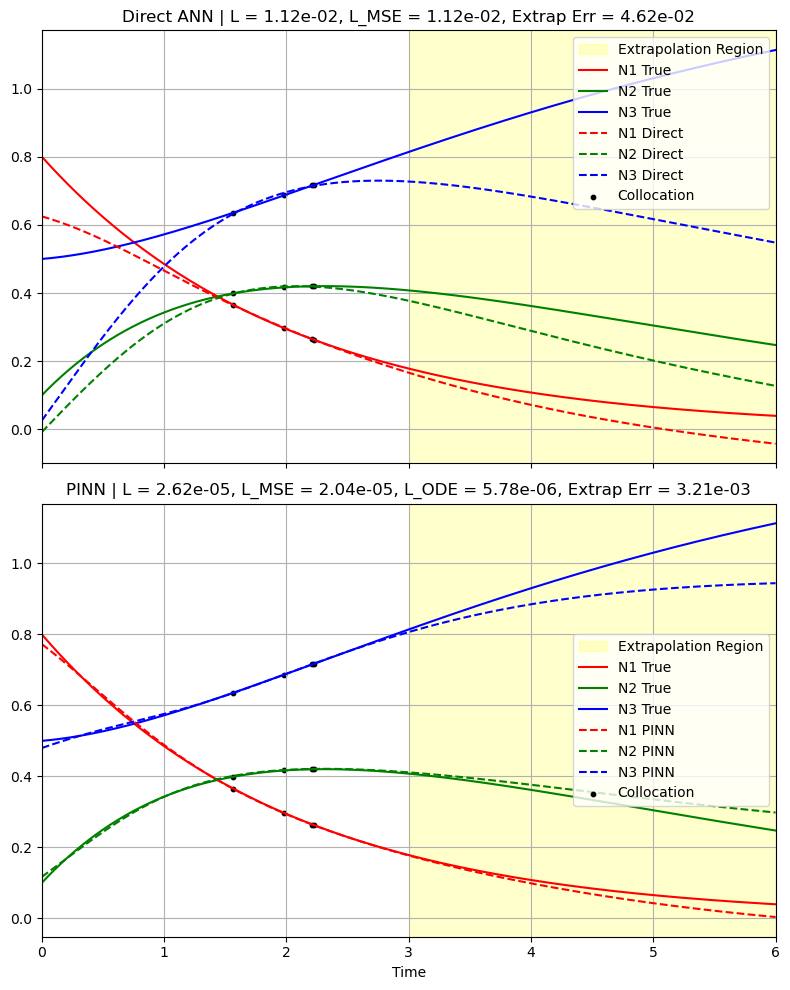

In [181]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

for ax in axs:
    ax.axvspan(t_end, t_end+prediction_time, color='yellow', alpha=0.2, label='Extrapolation Region')

# Top: Direct ANN
axs[0].plot(t_total, N1_true_total, 'r', label='N1 True')
axs[0].plot(t_total, N2_true_total, 'g', label='N2 True')
axs[0].plot(t_total, N3_true_total, 'b', label='N3 True')
axs[0].plot(t_total, pred_direct_total[:, 0], 'r--', label='N1 Direct')
axs[0].plot(t_total, pred_direct_total[:, 1], 'g--', label='N2 Direct')
axs[0].plot(t_total, pred_direct_total[:, 2], 'b--', label='N3 Direct')
axs[0].scatter(t[indices], N1[indices], c='k', s=10)
axs[0].scatter(t[indices], N2[indices], c='k', s=10)
axs[0].scatter(t[indices], N3[indices], c='k', s=10, label='Collocation')
axs[0].set_xlim([t_start, t_end + prediction_time])
axs[0].set_title(f"Direct ANN | L = {L_direct_total:.2e}, L_MSE = {L_direct_mse:.2e}, Extrap Err = {error_direct:.2e}")
axs[0].legend()
axs[0].grid(True)

# Bottom: PINN
axs[1].plot(t_total, N1_true_total, 'r', label='N1 True')
axs[1].plot(t_total, N2_true_total, 'g', label='N2 True')
axs[1].plot(t_total, N3_true_total, 'b', label='N3 True')
axs[1].plot(t_total, pred_pinn_total[:, 0], 'r--', label='N1 PINN')
axs[1].plot(t_total, pred_pinn_total[:, 1], 'g--', label='N2 PINN')
axs[1].plot(t_total, pred_pinn_total[:, 2], 'b--', label='N3 PINN')
axs[1].scatter(t[indices], N1[indices], c='k', s=10)
axs[1].scatter(t[indices], N2[indices], c='k', s=10)
axs[1].scatter(t[indices], N3[indices], c='k', s=10, label='Collocation')
axs[1].set_xlim([t_start, t_end + prediction_time])
axs[1].set_title(f"PINN | L = {L_pinn_total:.2e}, L_MSE = {L_pinn_mse:.2e}, L_ODE = {L_pinn_ode:.2e}, Extrap Err = {error_pinn:.2e}")
axs[1].legend()
axs[1].grid(True)

plt.xlabel("Time")
plt.tight_layout()
plt.savefig('Radioactive-decay_PINN.png', dpi=300)
plt.show()